# Setup

In [1]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle()

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import betScripts

from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from xgboost import XGBRegressor
import sklearn.metrics as skm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.cluster import AffinityPropagation as AP

import re
import time
import datetime as dt
import patoolib
import sys
import os
import zipfile
from collections import Counter

import urllib.request
from bs4 import BeautifulSoup
import requests

import warnings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

mpl.rcParams.update({'text.color' : 'white',
                    'axes.labelcolor': 'white',
                    'xtick.color': 'white',
                    'ytick.color': 'white'})
font = {'family' : 'fantasy',
        'weight' : 'normal',
        'size'   : 18}

mpl.rc('font', **font)
hide_toggle()

# Load files

In [3]:
name='RAW'
date='2022-09-20'
matchData,matchDetData,teamData,playerData,wChampData,rChampData,labelStatsdf,regions,regionBestCluster,hyperParams,regionsFeatureImp,useDf = betScripts.openFiles(date=date,name=name)
 
labelStatsdf.rename(columns={'totalKills':'label'},inplace=True)
useDf.rename(columns={'totalKills':'label'},inplace=True)

if name in ['RAW_M']:
    labelStatsdf['Region'] = labelStatsdf['Region2']
    useDf['Region'] = useDf['Region2']

labelStatsdf.rename(columns={'Region':'n'},inplace=True)
regions = regions.merge(labelStatsdf[['n','Init']],how='left',on='n').drop_duplicates()
labelStatsdf.rename(columns={'n':'Region'},inplace=True)

for x in labelStatsdf.columns:
    if x in ['Blue','Red','Code','Result','totalKills','totalKillsBlue','totalKillsRed','Region name','Init','Season','Size','Region2']: labelStatsdf.drop(x,axis=1,inplace=True)

labelStatsdf.dropna(inplace=True)
labelStatsdf = labelStatsdf[labelStatsdf['label']!=0]
labelStatsTemp = labelStatsdf.copy()
labelStatsTemp = labelStatsTemp[(np.abs(stats.zscore(labelStatsTemp['label'])) < 3)]

useDf = useDf[useDf['label']!=0]

regions = regions[regions['n'].isin(labelStatsdf['Region'].unique())]
regions.reset_index(drop=True,inplace=True)

if name not in ['RAW','RAW_M']:regionBestCluster=regionBestCluster[0]

Extracting
Loading matchData_2022-09-20.csv...
Loading matchDetData_2022-09-20.csv...
Loading teamData_2022-09-20.csv...
Loading playerData_2022-09-20.csv...
Loading wChampData_2022-09-20.csv...
Loading rChampData_2022-09-20.csv...
Loading labelStatsdf_2022-09-20.csv...
Loading regions_2022-09-20.csv...
Loading hyperParams_2022-09-20.csv...
Loading regionsFeatureImp_2022-09-20.csv...
Loading useDf_2022-09-20.csv...
Loading Complete!


# Functions

In [4]:
def evaluate1(model, test_features, test_labels):
    
    predictions = model.predict(test_features)
    errors = predictions - test_labels
    resultTest = pd.DataFrame()
    
    return errors,predictions

def evaluate2(predictions,test_labels,testing,col,botBase,topBase,pred):
    
    tp=[]
    
    threshold=testing
    meanPred = (np.mean(predictions))
    if pred!=-1:
        meanPred=pred
        threshold=0
        
    print(meanPred+threshold)
    print(predictions)    
    for x in range(len(predictions)):
            
        if (col=='ceiling') & ((predictions[x])>meanPred+threshold):
            if (botBase<=test_labels[x]):
                tp.append(1)
            else:
                tp.append(0)
                
        if (col=='floor') & ((predictions[x])<meanPred+threshold):
            if(topBase>=test_labels[x]): 
                tp.append(1)
            else: tp.append(0)
            
    tp2 = tp.count(1)/len(tp)*100 if len(tp)>0 else 0
    perc = len(tp)/len(predictions)
    
    return tp2,perc

def plotOverview(col,region,usePred):
    reg=region

    regName=regions['region'][reg].replace('%20',' ')
    tresholdC = regions['ceiling'][reg]
    tresholdF = regions['floor'][reg]
    lsdf = labelStatsTemp.replace(reg,-1).sort_values(by='Region',ascending=True).copy()
    lsdf = lsdf[lsdf['Region'].isin(regionBestCluster[str(reg)])]
    
    featuresUse =  list(regionsFeatureImp[str(region)].dropna().index.values)
    
    testdf = lsdf[lsdf['Region']==-1].copy()
    testdf = testdf[lsdfCols]
    xtest = testdf.drop('label',axis=1).copy()
    ytest = testdf['label'].copy()

    traindf = lsdf[lsdf['Region']!=-1].copy()
    traindf = traindf[lsdfCols]
    xtrain =  traindf.drop('label',axis=1).copy()
    ytrain =  traindf['label'].copy()

    if len(traindf)<1:
        lsdfShort = lsdf.copy()
        lsdfShort = lsdfShort[lsdfCols]
        features = lsdfShort.drop(['label'],axis=1)
        label = lsdfShort['label']

        xtrain, xtest, ytrain, ytest = train_test_split(features, label, train_size=0.75, random_state=42)
        
    base_model = XGBRegressor()
    base_model.fit(xtrain, ytrain)
    
    errors,predPlot = evaluate1(base_model,xtest,ytest)
    
    win,perc = evaluate2(predPlot,ytest.reset_index(drop=True),regions[col][reg],col,regions['botBase'][reg],regions['topBase'][reg],usePred)
    
    meanPred = np.mean(predPlot)
    
    return predPlot,ytest,win,perc,meanPred
    
hide_toggle()

# Modeling

### Region data selection + Feature importance

In [65]:
regions['rID'] = regions['Init']+'_'+regions['year']

for l in regions['n']:
    if any(y in regions['region'][l].split('%20') for y in ['Playoffs','Finals','Play-In','Ultraliga']): regions = regions[regions['n']!=l]
        
for l in regions['n']:
    if len(regions[regions['rID']==regions['rID'][l]])<2: regions = regions[regions['n']!=l]
        
regions = regions.sort_values(by=['region','rID'],ascending=[True,True]).reset_index(drop=True).drop(['Init'],axis=1)

In [5]:
ongoingRegs = [62,1,91,31,89,38,85,30,93,41,86,25,229,168,242,174,215,155,164,214,196,133,217,158]#(regions[regions['year']=='2022'])['n']

if len(ongoingRegs)<1: ongoingRegs=regions['n']
regions['ongoing'] = False
regions.index=regions['n']

for l in regions['n']:
    if regions['n'][l] in ongoingRegs:
        regions['ongoing'][l] = True

toScan = []
regions

,n,region,season,year,Init,ongoing
n,,,,,,
0,0,LFL%20Promotion%202023,Spring,2023,LFL,False
1,1,EU%20Masters%20Summer%202022,Summer,2022,EU,True
2,2,LCS%20Championship%202022,Summer,2022,LCS,False
3,3,LEC%20Summer%20Playoffs%202022,Summer,2022,LEC,False
4,4,CBLOL%20Academy%20Split%202%20Playoffs%202022,Summer,2022,CBLOLAcademy,False
5,5,TCL%20Summer%20Playoffs%202022,Summer,2022,TCL,False
6,6,PCS%20Summer%20Playoffs%202022,Summer,2022,PCS,False
7,7,LCO%20Split%202%20Playoffs%202022,Summer,2022,LCO,False
8,8,LJL%20Summer%20Playoffs%202022,Summer,2022,LJL,False


In [6]:
regionBestCluster={}
regions['bestResult']=0.0
regionsFeatureImp = pd.DataFrame()

toScan=[]

In [7]:
%%time
pd.set_option('display.float_format', lambda x: '%.5f' % x)

if len(toScan)<1: toScan=regions[regions['ongoing']==True]['n']

for region in toScan:
    cluster5 = [-1,region]
    cont=0
    print(region)
    if False not in regions['ongoing']: print('======RELOAD REGIONS!!!======')
        
    featureToPrint=[]
    featureImp=pd.DataFrame(columns=['index',0]).set_index(['index'])
    
    for reg in regions['n'].sort_values(ascending=True):
        
        lsdf = labelStatsTemp.replace(region,-1).sort_values(by='Region',ascending=True).copy()
        
        clusterTest=cluster5.copy()
        if cont!=0:
            clusterTest.append(reg)
        
        lsdf = lsdf[lsdf['Region'].isin(clusterTest)]
        
        testdf = lsdf[lsdf['Region']==-1].copy()

        valdf = testdf[int(len(testdf)/2):]
        testdf = testdf.iloc[0:int(len(testdf)/2)]
        xtest = testdf.drop('label',axis=1).copy()
        ytest = testdf['label'].copy()
    
        xval =  valdf.drop('label',axis=1).copy()
        yval =  valdf['label'].copy()
        
        traindf = lsdf[lsdf['Region']!=-1].copy()
        xtrain =  traindf.drop('label',axis=1).copy()
        ytrain =  traindf['label'].copy()
        
        if len(traindf)<1:
            
            features = lsdf.drop(['label'],axis=1)
            label = lsdf['label']
            
            xval =  features[int(len(features)*0.75):]
            yval =  label[int(len(label)*0.75):]
            
            features = features[0:int(len(testdf)*0.75)]
            label = label[0:int(len(testdf)*0.75)]
            xtrain, xtest, ytrain, ytest = train_test_split(features, label, train_size=0.75, random_state=42)
        
        model = XGBRegressor()
        model.fit(xtrain, ytrain)

        errors3=0
        for i in range(5):
            errors,predictions = evaluate1(model,xtest,ytest)
            errors3=np.mean(abs(errors))+errors3
        errors2=errors3/5
        
        errors3=0
        for i in range(5):
            errors,predictions = evaluate1(model,xval,yval)
            errors3=np.mean(abs(errors))+errors3
        errors4=errors3/5

        errors2=(errors2+errors4)/2
        
        if cont==0: 
            bestResult=errors2
            featureImp = pd.DataFrame(model.feature_importances_,xtrain.columns).reset_index()
            featureToPrint = featureImp.sort_values(by=0,ascending=False).iloc[:10]
        elif (cont!=0) & (bestResult > errors2):
            bestResult=errors2
            cluster5.append(reg)
            print(cluster5)
            featureImp = pd.DataFrame(model.feature_importances_,xtrain.columns).reset_index()
            featureToPrint = featureImp.sort_values(by=0,ascending=False).iloc[:10]
            
        cont+=1
    
    print(f'===============\n{bestResult}\n===============')
    #print(featureToPrint)
    print('==========================================')
    regions['bestResult'][region] = bestResult
    regionBestCluster[f'{region}'] = cluster5
    featureImp = featureImp.transpose()
    featureRow = featureImp.rename(columns=featureImp.loc['index']).drop('index')
    featureRow.index = [region]
    regionsFeatureImp = pd.concat([regionsFeatureImp,featureRow.transpose()],axis=1)

rawRegions = regions.copy()
regions = regions[regions['ongoing']==True]
#regions.drop('ongoing',axis=1,inplace=True)

pd.set_option('display.float_format', lambda x: '%.2f' % x)
hide_toggle()

1
[-1, 1, 3]
[-1, 1, 3, 5]
[-1, 1, 3, 5, 6]
[-1, 1, 3, 5, 6, 10]
[-1, 1, 3, 5, 6, 10, 13]
[-1, 1, 3, 5, 6, 10, 13, 18]
[-1, 1, 3, 5, 6, 10, 13, 18, 23]
[-1, 1, 3, 5, 6, 10, 13, 18, 23, 38]
[-1, 1, 3, 5, 6, 10, 13, 18, 23, 38, 60]
[-1, 1, 3, 5, 6, 10, 13, 18, 23, 38, 60, 74]
5.9788196086883545
25
[-1, 25, 2]
[-1, 25, 2, 10]
[-1, 25, 2, 10, 14]
[-1, 25, 2, 10, 14, 15]
[-1, 25, 2, 10, 14, 15, 18]
[-1, 25, 2, 10, 14, 15, 18, 19]
[-1, 25, 2, 10, 14, 15, 18, 19, 40]
[-1, 25, 2, 10, 14, 15, 18, 19, 40, 53]
[-1, 25, 2, 10, 14, 15, 18, 19, 40, 53, 153]
6.716648192632766
30
[-1, 30, 1]
[-1, 30, 1, 2]
[-1, 30, 1, 2, 6]
[-1, 30, 1, 2, 6, 13]
[-1, 30, 1, 2, 6, 13, 14]
[-1, 30, 1, 2, 6, 13, 14, 38]
[-1, 30, 1, 2, 6, 13, 14, 38, 53]
[-1, 30, 1, 2, 6, 13, 14, 38, 53, 55]
[-1, 30, 1, 2, 6, 13, 14, 38, 53, 55, 177]
6.5406590227810835
31
5.085163967426007
38
[-1, 38, 1]
[-1, 38, 1, 2]
[-1, 38, 1, 2, 10]
[-1, 38, 1, 2, 10, 13]
[-1, 38, 1, 2, 10, 13, 14]
[-1, 38, 1, 2, 10, 13, 14, 15]
[-1, 38, 1, 2, 10, 13

### Feature selection

In [8]:
regions['bestResultF'] = 0.0

In [9]:
%%time

for reg in regionsFeatureImp:

    priorityList = list(regionsFeatureImp[reg].sort_values(ascending=False).index.values)
    finalList = priorityList.copy()
    bestResult = regions['bestResult'][int(reg)]
    
    print(reg)
    print(regionBestCluster[str(reg)])
    for n,x in enumerate(priorityList):
        lsdf = labelStatsTemp.replace(int(reg),-1).sort_values(by='Region',ascending=True).copy()
        lsdf = lsdf[lsdf['Region'].isin(regionBestCluster[str(reg)])]
        
        if n!=0:
            featureCheck=x
            priorityList.remove(featureCheck)
            lsdfCols = priorityList.copy()
            lsdfCols.append('label')
        else: 
            lsdfCols = priorityList.copy()
            lsdfCols.append('label')
        
        testdf = lsdf[lsdf['Region']==-1].copy()
        testdf = testdf[lsdfCols]

        valdf = testdf[int(len(testdf)/2):].copy()
        testdf = testdf.iloc[0:int(len(testdf)/2)]
        
        xtest = testdf.drop('label',axis=1).copy()
        ytest = testdf['label'].copy()
    
        xval =  valdf.drop('label',axis=1).copy()
        yval =  valdf['label'].copy()
        
        traindf = lsdf[lsdf['Region']!=-1].copy()
        traindf = traindf[lsdfCols]
        xtrain =  traindf.drop('label',axis=1).copy()
        ytrain =  traindf['label'].copy()

        if len(traindf)<1:
            
            lsdfShort = lsdf.copy()
            lsdfShort = lsdfShort[lsdfCols]
            
            features = lsdfShort.drop(['label'],axis=1)
            label = lsdfShort['label']

            xval =  features[int(len(features)*0.75):]
            yval =  label[int(len(label)*0.75):]

            features = features[0:int(len(testdf)*0.75)]
            label = label[0:int(len(testdf)*0.75)]
            xtrain, xtest, ytrain, ytest = train_test_split(features, label, train_size=0.75, random_state=42)

        model = XGBRegressor()
        model.fit(xtrain, ytrain)
        
        errors3=0
        rep=5
        for i in range(rep):
            errors,predictions = evaluate1(model,xtest,ytest)
            errors3=np.mean(abs(errors))+errors3
        errors2=errors3/rep
        
        errors3=0
        for i in range(rep):
            errors,predictions = evaluate1(model,xval,yval)
            errors3=np.mean(abs(errors))+errors3
        errors4=errors3/rep
        
        errors2=(errors2+errors4)/2
        
        if (bestResult>errors2):
            bestResult=errors2
            if n!=0: 
                finalList.remove(featureCheck)
                finalList.append('nan')
        else: 
            if n!=0: priorityList.append(featureCheck)
            
    print(bestResult)
    nantoprint='nan'
    print(f'{len(pd.DataFrame(finalList,columns=[0])[pd.DataFrame(finalList,columns=[0])[0]!=nantoprint])} of {len(finalList)}')
    print('==================================|||||||||')
    
    for y in regionsFeatureImp[reg].index.values:
        if y not in finalList:
            regionsFeatureImp[reg][y] = np.nan
    
    regions['bestResultF'][reg] = bestResult

regionsFeatureImp.columns = [str(x) for x in list(regionsFeatureImp.columns)]

hide_toggle()

1
[-1, 1, 3, 5, 6, 10, 13, 18, 23, 38, 60, 74]
5.9788196086883545
73 of 73
==================================|||||||||
25
[-1, 25, 2, 10, 14, 15, 18, 19, 40, 53, 153]
6.716648192632766
73 of 73
==================================|||||||||
30
[-1, 30, 1, 2, 6, 13, 14, 38, 53, 55, 177]
6.5406590227810835
73 of 73
==================================|||||||||
31
[-1, 31]
5.085163967426007
73 of 73
==================================|||||||||
38
[-1, 38, 1, 2, 10, 13, 14, 15, 18, 30, 37, 40, 135]
6.448285784040179
73 of 73
==================================|||||||||
41
[-1, 41, 1, 2, 12, 17, 31, 32, 33, 36, 45, 240]
5.8749522333559785
73 of 73
==================================|||||||||
62
[-1, 62]
5.65150377087127
73 of 73
==================================|||||||||
85
[-1, 85, 1, 2, 6, 13, 19, 32]
6.487841485773476
73 of 73
==================================|||||||||
86
[-1, 86]
4.440735975901285
73 of 73
==================================|||||||||
89
[-1, 89]
5.529219695499965
73 of 73
====

### Thresholds

In [10]:
fill=0.0

regions['bestResultH']=fill
regions['ceiling']=fill
regions['ceilingWin']=fill
regions['ceilingPer']=fill
regions['ceilingLimit']=fill
regions['floor']=fill
regions['floorWin']=fill
regions['floorPer']=fill
regions['floorLimit']=fill
regions['size']=fill
regions['meanPred']=fill

hide_toggle()

In [11]:
fB = 24.5
cB = 26.5
regions['topBase'] = cB
regions['botBase'] = fB

bases = ([
        
        ])

bases = pd.DataFrame(bases, columns=['Region','botBase','topBase'])

for x in range(len(bases)):
    regions['botBase'][bases['Region'][x]] = bases['botBase'][x]
    regions['topBase'][bases['Region'][x]] = bases['topBase'][x]
    
hide_toggle()

In [73]:
%%time

if len(toScan)<1: toScan=regions['n']

for reg in toScan:
    region=reg
    print('================================')
    print(reg)

    regions['bestResultH'][reg]=fill
    
    cluster = regionBestCluster[str(region)].copy()

    regionsFilter = labelStatsTemp[labelStatsTemp['Region'].isin(cluster)]
    
    lsdf = regionsFilter.replace(region,-1).sort_values(by='Region',ascending=True).copy()
    
    featuresUse =  list(regionsFeatureImp[str(region)].dropna().index.values)
    featuresUse.append('label')
    
    testdf = lsdf[lsdf['Region']==-1].sample(frac=1).copy()
    testdf = testdf[featuresUse]

    valdf = testdf[int(len(testdf)/2):]
    valdf = valdf[featuresUse]
    testdf = testdf.iloc[0:int(len(testdf)/2)]
    
    xtest = testdf.drop('label',axis=1).copy()
    ytest = testdf['label'].copy()
    
    xval =  valdf.drop('label',axis=1).copy()
    yval =  valdf['label'].copy()

    traindf = lsdf[lsdf['Region']!=-1].copy()
    traindf = traindf[featuresUse]
    xtrain =  traindf.drop('label',axis=1).copy()
    ytrain =  traindf['label'].copy()

    if len(traindf)<1:

        lsdfShort = lsdf.copy()
        lsdfShort = lsdfShort[featuresUse]

        features = lsdfShort.drop(['label'],axis=1)
        label = lsdfShort['label']

        xval =  features[int(len(features)*0.75):]
        yval =  label[int(len(label)*0.75):]

        features = features[0:int(len(testdf)*0.75)]
        label = label[0:int(len(testdf)*0.75)]
        
        xtrain, xtest, ytrain, ytest = train_test_split(features, label, train_size=0.75, random_state=42)
            
    for col in ['ceiling','floor']:
        
        regions[col][region] = 0.0
        regions[f'{col}Win'][region] = 0.0
        regions[f'{col}Per'][region] = 0.0
        regions['meanPred'][reg] = 0.0
        
        for dataX,dataY in zip(['xt','xv'],['yt','yv']):
        
            if dataX=='xt': dataX=xtest.reset_index(drop=True)
            elif dataX=='xv': dataX=xval.reset_index(drop=True)

            if dataY=='yt': dataY=ytest.reset_index(drop=True)
            elif dataY=='yv': dataY=yval.reset_index(drop=True)
    
            base_model = XGBRegressor()
            base_model.fit(xtrain, ytrain)

            ceilingtest = pd.DataFrame(columns=[0,1,2,3])
            if col=='ceiling': ceilingtest[0] = [i/100 for i in range(-400,200)]
            else: ceilingtest[0] = [i/100 for i in range(-300,100)]
            for x in [1,2,3]:
                ceilingtest[x] = 0
            
            meanErr=[]
            for contMean in list(range(0,10)):
                errors,predictions = evaluate1(base_model,dataX,dataY)
                
                meanErr.append(np.mean([abs(x) for x in errors]))

                errors=list(errors)
                predictions=list(predictions)

                for n in range(len(ceilingtest)):
                    tp,tests = evaluate2(predictions,dataY,ceilingtest[0][n],col,regions['botBase'][reg],regions['topBase'][reg],-1)
                    ceilingtest[1][n] = (float(tp))+ceilingtest[1][n]
                    ceilingtest[2][n] = (tests*100)+ceilingtest[2][n]
                    ceilingtest[3][n] = ((ceilingtest[1][n]+ceilingtest[2][n])/2)+ceilingtest[3][n]
            
            meanErr=np.mean(meanErr)
            
            print('meanerr old')
            print(regions['bestResultF'][region])
            print('meanerr')
            print(meanErr)
            print('========')
            regions['bestResultH'][region] += meanErr
                    
            
            for x in [1,2,3]:
                ceilingtest[x] = ceilingtest[x]/10

            filterPerc = ceilingtest.loc[(ceilingtest[2]>20) & (ceilingtest[1]>=80)].copy()
            if len(filterPerc)<1: filterPerc = ceilingtest.loc[(ceilingtest[1]>=80)].copy()
            if len(filterPerc)<1: filterPerc = ceilingtest.loc[(ceilingtest[1]==max(ceilingtest[1]))].copy()


            regions['meanPred'][reg] = round(np.mean(predictions)+regions['meanPred'][reg],2)
            regions[col][region] = ((filterPerc[filterPerc[1]==max(filterPerc[1])].reset_index())[0][0])+regions[col][region]
            regions[f'{col}Win'][region] = round((filterPerc[filterPerc[3]==max(filterPerc[3])].reset_index())[1][0]+regions[f'{col}Win'][region],2)
            regions[f'{col}Per'][region] = round((filterPerc[filterPerc[3]==max(filterPerc[3])].reset_index())[2][0]+regions[f'{col}Per'][region],2)

            regions['size'][region] = len(predictions)*2
            if col=='ceiling':
                regions[f'{col}Limit'][region] = float(ceilingtest.loc[ceilingtest[1]==max(ceilingtest[1])][0][-1:])
            else:regions[f'{col}Limit'][region] = float(ceilingtest.loc[ceilingtest[1]==max(ceilingtest[1])][0].iloc[0])

        regions[col][region] = round(regions[col][region]/2,2)
        regions[f'{col}Win'][region] = round(regions[f'{col}Win'][region]/2,2)
        regions[f'{col}Per'][region] = round(regions[f'{col}Per'][region]/2,2)
        regions['meanPred'][reg] = round(regions['meanPred'][reg]/2,2)
        
    regions['bestResultH'][region] = regions['bestResultH'][region]/4
    print(regions['bestResultH'][region])
try:
    hyperParams.reset_index(inplace=True)
    hyperParams.index = hyperParams['n']
except:True

hide_toggle()

24
meanerr old
7.313362714979384
meanerr
6.776803716023762
meanerr old
7.313362714979384
meanerr
8.084060202704535
meanerr old
7.313362714979384
meanerr
6.776803716023762
meanerr old
7.313362714979384
meanerr
8.084060202704535
7.430431959364149
29
meanerr old
8.955262480841743
meanerr
10.372981516520182
meanerr old
8.955262480841743
meanerr
8.221715884738499
meanerr old
8.955262480841743
meanerr
10.372981516520182
meanerr old
8.955262480841743
meanerr
8.221715884738499
9.29734870062934
14
meanerr old
5.207637889044625
meanerr
5.159568377903531
meanerr old
5.207637889044625
meanerr
5.726259844643729
meanerr old
5.207637889044625
meanerr
5.159568377903531
meanerr old
5.207637889044625
meanerr
5.726259844643729
5.44291411127363
18
meanerr old
7.680351463524071
meanerr
7.707283741719013
meanerr old
7.680351463524071
meanerr
7.653419185329128
meanerr old
7.680351463524071
meanerr
7.707283741719013
meanerr old
7.680351463524071
meanerr
7.653419185329128
7.680351463524071
6
meanerr old
5.8863

meanerr old
6.663693063243686
meanerr
6.708989329960035
meanerr old
6.663693063243686
meanerr
6.648484838769791
meanerr old
6.663693063243686
meanerr
6.708989329960035
meanerr old
6.663693063243686
meanerr
6.648484838769791
6.678737084364913
20
meanerr old
8.254255326588947
meanerr
8.82549171447754
meanerr old
8.254255326588947
meanerr
7.705378977457682
meanerr old
8.254255326588947
meanerr
8.82549171447754
meanerr old
8.254255326588947
meanerr
7.705378977457682
8.26543534596761
55
meanerr old
5.2310467190212675
meanerr
5.648019705878363
meanerr old
5.2310467190212675
meanerr
5.318523025512695
meanerr old
5.2310467190212675
meanerr
5.648019705878363
meanerr old
5.2310467190212675
meanerr
5.318523025512695
5.483271365695529
49
meanerr old
6.258880581174578
meanerr
7.309292248317173
meanerr old
6.258880581174578
meanerr
6.046827929360526
meanerr old
6.258880581174578
meanerr
7.309292248317173
meanerr old
6.258880581174578
meanerr
6.046827929360526
6.6780600888388495
54
meanerr old
5.9030

# Prediction

In [74]:
redCols = ['SUP:GamesRed', 'SUP:Win RateRed', 'SUP:KDARed', 'SUP:AVG KillsRed','SUP:AVG DeathsRed', 'SUP:AVG AssistsRed', 
 'BOT:GamesRed', 'BOT:Win RateRed', 'BOT:KDARed', 'BOT:AVG KillsRed','BOT:AVG DeathsRed', 'BOT:AVG AssistsRed', 
 'MID:GamesRed', 'MID:Win RateRed', 'MID:KDARed', 'MID:AVG KillsRed','MID:AVG DeathsRed', 'MID:AVG AssistsRed', 
 'JNG:GamesRed', 'JNG:Win RateRed', 'JNG:KDARed', 'JNG:AVG KillsRed','JNG:AVG DeathsRed', 'JNG:AVG AssistsRed', 
 'TOP:GamesRed', 'TOP:Win RateRed', 'TOP:KDARed', 'TOP:AVG KillsRed','TOP:AVG DeathsRed', 'TOP:AVG AssistsRed',
 'Team:Win RateRed','Team:KDARed','Team:AVG KillsRed','Team:AVG DeathsRed','Team:AVG AssistsRed','Team:GamesRed','Region']

blueCols = ['SUP:Games', 'SUP:Win Rate', 'SUP:KDA', 'SUP:AVG Kills','SUP:AVG Deaths', 'SUP:AVG Assists', 
 'BOT:Games', 'BOT:Win Rate', 'BOT:KDA', 'BOT:AVG Kills','BOT:AVG Deaths', 'BOT:AVG Assists', 
 'MID:Games', 'MID:Win Rate', 'MID:KDA', 'MID:AVG Kills','MID:AVG Deaths', 'MID:AVG Assists', 
 'JNG:Games', 'JNG:Win Rate', 'JNG:KDA', 'JNG:AVG Kills','JNG:AVG Deaths', 'JNG:AVG Assists', 
 'TOP:Games', 'TOP:Win Rate', 'TOP:KDA', 'TOP:AVG Kills','TOP:AVG Deaths', 'TOP:AVG Assists',
 'Team:Win Rate','Team:KDA','Team:AVG Kills','Team:AVG Deaths','Team:AVG Assists','Team:Games','Region']

hide_toggle()

In [75]:
regions#[['n','bestResultH']]#.sort_values(by='region')[regions['n'].isin(toScan)]

,n,region,season,ongoing,bestResult,bestResultF,bestResultH,ceiling,ceilingWin,ceilingPer,ceilingLimit,floor,floorWin,floorPer,floorLimit,size,meanPred,topBase,botBase
n,,,,,,,,,,,,,,,,,,,
24,24,CBLOL%20Split%201%202022,Spring,True,7.41,7.31,7.43,-0.01,80.00,44.00,0.48,-2.64,65.00,26.50,-2.83,90.00,27.52,27.50,24.50
29,29,CBLOL%20Academy%20Split%201%202022,Spring,True,9.27,8.96,9.30,-1.74,71.00,58.50,-2.12,-1.49,69.50,35.00,-2.11,90.00,25.94,27.50,24.50
14,14,EBL%20Spring%202022,Spring,True,5.94,5.21,5.44,-1.98,72.00,67.50,0.27,-2.08,82.50,26.50,-1.16,56.00,28.68,27.50,24.50
18,18,EU%20Masters%20Spring%202022,Spring,True,7.68,7.68,7.68,0.19,75.50,38.50,0.67,-3.00,66.00,24.00,-3.00,74.00,27.61,27.50,24.50
6,6,Elite%20Series%20Spring%202022,Spring,True,5.89,5.89,5.89,-2.08,78.50,72.50,1.99,-2.46,71.50,19.00,-3.00,56.00,28.42,27.50,24.50
9,9,GLL%20Spring%202022,Spring,True,7.44,7.44,7.44,0.61,86.00,60.50,0.06,-1.36,70.50,31.50,-3.00,56.00,28.70,27.50,24.50
16,16,Hitpoint%20Masters%20Spring%202022,Spring,True,7.82,7.64,7.48,-1.86,81.00,65.50,-3.50,-1.42,73.50,40.50,-0.84,56.00,28.38,27.50,24.50
8,8,LCK%20Spring%202022,Spring,True,5.03,4.77,7.23,-3.36,30.00,79.00,-1.45,-0.90,80.50,57.00,-1.75,42.00,25.45,27.50,24.50
21,21,LCK%20CL%20Spring%202022,Spring,True,6.96,6.96,6.96,-1.20,64.50,58.00,1.99,-1.70,72.00,40.50,-3.00,168.00,25.22,27.50,24.50


In [633]:
region=60

regionN=regions['region'][region].replace('%20',' ')
ceilingWin = regions['ceilingWin'][region]
ceilingPer = regions['ceilingPer'][region]
floorWin = regions['floorWin'][region]
floorPer = regions['floorPer'][region]
size = regions['size'][region]

print(f'{regionN}\nceilingWin: {ceilingWin}\nceilingPer: {ceilingPer}\n\nfloorWin: {floorWin}\nfloorPer: {floorPer}\n\nsize: {2*size}')
teamData[teamData['Region']==region]

EU Masters Summer Play-In 2022
ceilingWin: 78.5
ceilingPer: 74.5

floorWin: 84.5
floorPer: 40.0

size: 104.0


,Region,Name,Win rate,K:D,GPM,Kills / game,Towers killed,Towers lost,DPM,Deaths / game,SUP,BOT,MID,JNG,TOP,Init,Season
teamData,,,,,,,,,,,,,,,,,
562,60.00,Anorthosis Famagusta Esports,77.80,1.31,1996.00,17.00,8.60,4.00,2439.00,12.90,iLevi,goldento4st,Dom1nant,Daglas,Adiss,EU,Summer
563,60.00,BISONS ECLUB,50.00,1.01,1871.00,16.30,5.70,6.00,2618.00,16.20,Oscure,Guubi,Random,Alby,Myrwn,EU,Summer
564,60.00,Crvena zvezda Esports,16.70,0.53,1702.00,9.30,3.00,8.70,1862.00,17.30,Tasteless,Ecstassy,Hunt,Skude,dejan1,EU,Summer
565,60.00,Entropiq,0.00,0.37,1575.00,6.30,1.80,9.80,1951.00,17.30,-missing-,Denyk,Khantos,Eren,Rames,EU,Summer
566,60.00,For The Win Esports,55.60,0.92,1768.00,15.60,5.80,6.70,2342.00,16.90,Calmsky,Mindrago,Noma,Own3r,Jakoule,EU,Summer
567,60.00,GameWard,87.50,2.28,2035.00,22.80,9.60,3.00,2909.00,10.00,-missing-,kamilius,Innaxe,Czekolad,Akabane,EU,Summer
568,60.00,Illuminar Gaming,33.30,0.72,1740.00,10.70,4.80,7.00,1981.00,14.80,minemaciek,svns,many,adi11,Tracyn,EU,Summer
569,60.00,JD|XL,33.30,1.05,1798.00,11.50,6.00,7.20,1988.00,11.00,FGG,Venzer,Mrozku,dan,Kryze,EU,Summer
570,60.00,KRC Genk Esports,50.00,0.90,1799.00,14.10,6.30,6.40,2191.00,15.80,Moopz,Tiger,RoyalKanin,Guertas,Robba,EU,Summer


In [618]:
teams=[0,390,381]
regionsUnion=[58,65]
regionsUnion=[region]
col='floor'

region: 60
name: EU Masters Summer Play-In 2022
region size: 104


Blue team: Dusty
Red team: LDLC OL

Prediction: 34.5

mean pred: 27.779451370239258
mean pred old: 29.29

floor: 24.859451370239256
floor limit: 24.929451370239256

bet chance old: 42.0
bet chance: 93.0

win chance old: 76.0
win chance: 56.7

dont bet


Blue team: LDLC OL
Red team: Dusty

Prediction: 22.5

mean pred: 27.779451370239258
mean pred old: 29.29

floor: 24.859451370239256
floor limit: 24.929451370239256

bet chance old: 42.0
bet chance: 7.000000000000001

win chance old: 76.0
win chance: 57.14

bet on: topBase 29.5




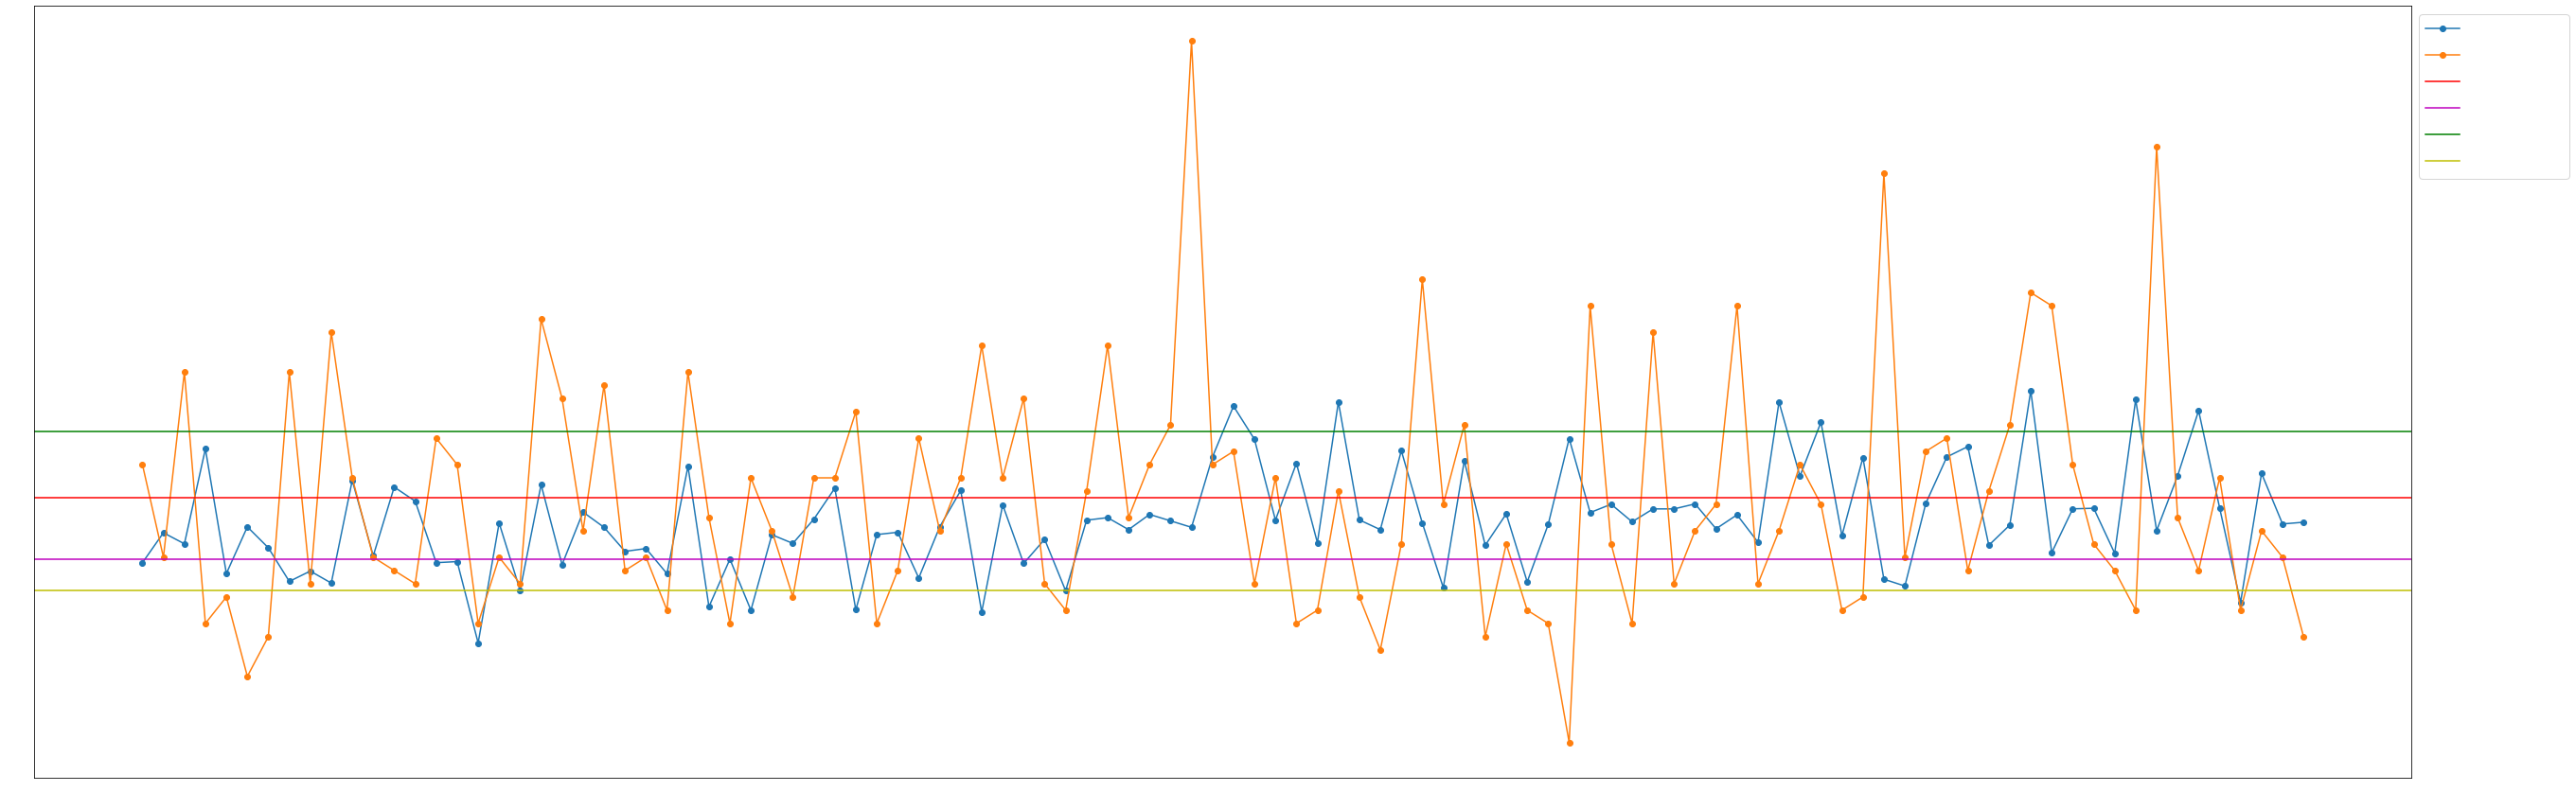

In [619]:
cont=-1
regName=regions['region'][region].replace('%20',' ')
for x in [0,1]:
    
    blueTeam = teamData['Name'][teams[cont]]
    redTeam = teamData['Name'][teams[cont*-1]]

    useDfTemp = useDf
        
    try:
        useDfBlue = (useDfTemp[useDfTemp['Blue']==blueTeam])[blueCols]
        useDfBlue = useDfBlue[useDfBlue['Region'].isin(regionsUnion)].iloc[0]
    except:
        useDfBlue = (useDfTemp[useDfTemp['Red']==blueTeam])[redCols]
        useDfBlue.columns = blueCols
        useDfBlue = useDfBlue[useDfBlue['Region'].isin(regionsUnion)].iloc[0]

    try:
        useDfRed = (useDfTemp[useDfTemp['Red']==redTeam])[redCols]
        useDfRed = useDfRed[useDfRed['Region'].isin(regionsUnion)].iloc[0]
    except:
        useDfRed = (useDfTemp[useDfTemp['Blue']==redTeam])[blueCols]
        useDfRed.columns = redCols
        useDfRed = useDfRed[useDfRed['Region'].isin(regionsUnion)].iloc[0]
    
    useDfRed.drop('Region',inplace=True)
    useDfPredict = pd.DataFrame(pd.concat([useDfBlue,useDfRed])).transpose()
    featuresUse =  list(regionsFeatureImp[str(region)].dropna().index.values)
    useDfPredict = useDfPredict[featuresUse].dropna(axis=1)

    lsdf = labelStatsdf[labelStatsdf['Region'].isin(regionBestCluster[str(region)])].dropna(axis=1)
    xtrain =  lsdf.drop('label',axis=1).copy()
    ytrain =  lsdf['label'].copy()
    xtrain = xtrain[featuresUse]

    base_model = XGBRegressor()

    base_model.fit(xtrain,ytrain)
    usePred = base_model.predict(useDfPredict)
    
    
    meanPredOld=regions['meanPred'][region]
    
    predPlot,predYtest,win,perc,meanPred = plotOverview(col,region,usePred)
    
    predCeiling=meanPred+regions['ceiling'][region]
    predFloor=meanPred+regions['floor'][region]
    
    if x==0:
        print(f'region: {region}\nname: {regName}\nregion size: {len(predYtest)}')
        toplot = pd.DataFrame([predPlot,predYtest]).transpose().rename(columns={0:'Predictions',1:'Label'})
        toplot.plot(figsize=(45,15),linestyle='-',marker='o')
        print('\n==========================\n')
    
    base = 'topBase' if col=='floor' else 'botBase'
    if x==0:
        plt.axhline(y=regions[base][region], color='r', linestyle='-',label=base)
        plt.axhline(y=meanPred+regions[col][region], color='m', linestyle='-',label=col)

    print(f'Blue team: {blueTeam}\nRed team: {redTeam}\n\nPrediction: {round(float(usePred),2)}\n')

    betChance=regions[f'{col}Per'][region]
    winChance=regions[f'{col}Win'][region]
    limit=meanPred+regions[col][region]
    colLimit=meanPred+regions[f'{col}Limit'][region]
    print(f'mean pred: {meanPred}\nmean pred old: {meanPredOld}\n')
    print(f'{col}: {limit}\n{col} limit: {colLimit}\n\nbet chance old: {betChance}\nbet chance: {round(perc,2)*100}\n\nwin chance old: {winChance}\nwin chance: {round(win,2)}\n')
    
    if col=='floor':
        if usePred<meanPred+regions[col][region]:
            print(f'bet on: {base} {regions[base][region]}')
        elif win>70:
            print(f'not reached target | bet on: {base} {regions[base][region]}')
        else:print('dont bet')
    else:
        if usePred>meanPred+regions[col][region]:
            print(f'bet on: {base} {regions[base][region]}')
        elif win>70:
            print(f'not reached target | bet on: {base} {regions[base][region]}')
        else:print('dont bet')

    print('\n==========================\n')
    
    cl='g' if x==0 else 'y'
    if teams[0]==0: plt.axhline(y=usePred, color=cl, linestyle='-',label='Predicted')
    plt.legend(bbox_to_anchor=(1.07, 1))
        
    cont*=-1

hide_toggle()

# Swap regions

In [76]:
# regPredictL = (regions[regions['season']=='Summer']).reset_index(drop=True)['n']
# regDataL = (regions[regions['season']=='Spring']).reset_index(drop=True)['n']

In [12]:
regPredictL=[]
regDataL=[]

regions['rID'] = regions['Init']+'_'+regions['year']
regions = regions.sort_values(by=['rID','region','year','season'])
regions['num']=[0,1,2,3]*6

for num in regions.num.unique()[:-1]:
    
    regPredictL.extend(list(regions[regions['num']==num+1]['n']))
    regDataL.extend(list(regions[regions['num']==num]['n']))

In [119]:
regions

,n,region,season,year,Init,ongoing,bestResult,bestResultF,rID,num,bestResultH,ceiling,ceilingWin,ceilingPer,ceilingLimit,floor,floorWin,floorPer,floorLimit,size,meanPred,topBase,botBase
n,,,,,,,,,,,,,,,,,,,,,,,
196,196,EU%20Masters%20Spring%202021,Spring,2021,EU,True,6.12,6.12,EU_2021,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,26.50,24.50
133,133,EU%20Masters%20Summer%202021,Summer,2021,EU,True,7.11,7.11,EU_2021,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,26.50,24.50
62,62,EU%20Masters%20Spring%202022,Spring,2022,EU,True,5.65,5.65,EU_2022,2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,26.50,24.50
1,1,EU%20Masters%20Summer%202022,Summer,2022,EU,True,5.98,5.98,EU_2022,3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,26.50,24.50
215,215,LCK%20Spring%202021,Spring,2021,LCK,True,6.43,6.13,LCK_2021,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,26.50,24.50
155,155,LCK%20Summer%202021,Summer,2021,LCK,True,5.80,5.80,LCK_2021,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,26.50,24.50
91,91,LCK%20Spring%202022,Spring,2022,LCK,True,5.15,5.15,LCK_2022,2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,26.50,24.50
31,31,LCK%20Summer%202022,Summer,2022,LCK,True,5.09,5.09,LCK_2022,3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,26.50,24.50
217,217,LCO%20Split%201%202021,Spring,2021,LCO,True,5.72,5.72,LCO_2021,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,26.50,24.50
